In [386]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [387]:
def loadData (flow, meta):
    df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
    df1.columns = ['ID', 'Year', 'Mnth', 'Day', 'Flow0', 'SYM']
    df1['datetime'] = pd.to_datetime(df1[['Year', 'Mnth', 'Day']].rename(columns={'Year': 'year', 'Mnth': 'month', 'Day': 'day'}))
    df1.drop(['ID', 'Year', 'Mnth', 'Day'], axis=1, inplace=True)
    df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)
    df = pd.concat([df1, df2], axis=1)
    df = pd.get_dummies(df, columns=['SYM'], dummy_na=True)
    df.set_index('datetime', inplace=True)
    df.drop(['Hr'], axis=1, inplace=True)
    before = 3
    after = 3
    # for i in range(1, before + 1):
    #     df[f'Flow-{i}'] = df['Flow0'].shift(+i)  # Shift down by 1   
    for i in  range(1, after + 1):
        df[f'Flow+{i}'] = df['Flow0'].shift(-i)  # Shift up by 1   
    df = df.dropna()
    return df


df = loadData('Data/Idaho/13340000_streamflow_qc.txt', 'Data/Idaho/13340000_lump_maurer_forcing_leap.txt')


C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2938264861.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2938264861.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [389]:
def pct_diff(old, new):
    return (new-old) / old
def compute_rolling(df, horizon, col):
    label = f"rolling_{horizon}_{col}"

    df[label] = df[col].rolling(horizon).mean()
    df[f"{label}_pct"] = pct_diff(df[label], df[col])
    return df
rolling_horizons = [3, 14]

for horizon in rolling_horizons:
    for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'tmin(C)', 'Flow0', 'vp(Pa)']:
        df = compute_rolling(df, horizon, col)

df = df.fillna(0)
def expand_mean(df):
    return df.expanding(1).mean()

for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'tmin(C)', 'Flow0', 'vp(Pa)']:
    df[f'month_avg_{col}'] = df[col].groupby(df.index.month, group_keys=False).apply(expand_mean)
    df[f'day_avg_{col}'] = df[col].groupby(df.index.day_of_year, group_keys=False).apply(expand_mean)

In [390]:
Y = df['Flow0']  # Target variable
adjX = df.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
X = adjX.columns

In [392]:
# def backtest(df, model, X, Y, start=3650, step=90):
#     all_predictions = []

#     # Ensure Y is a Series and X is a list of column names
#     if isinstance(Y, pd.Series):
#         Y = Y.name 

#     # if isinstance(X, pd.DataFrame):
#         #     X = X.columns.tolist()
#     for i in range(start, df.shape[0], step):
#         train = df.iloc[:i,:]
#         test = df.iloc[i:(i+step),:]
            
#         X_train = train[X]
#         Y_train = train[Y]
#         X_test = test[X]

#         model.fit(X_train, Y_train, epochs=10)

#         preds = model.predict(X_test)

#         preds = pd.Series(preds.flatten(), index=test.index)
#         combined = pd.concat([test[Y], preds], axis=1)

#         combined.columns = ["actual", "prediction"]
#         combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

#         all_predictions.append(combined)
#     return pd.concat(all_predictions, axis=0)

In [393]:
# def permutation_importance(model, X_test, y_test, metric=mean_squared_error):
#     baseline_score = metric(y_test, model.predict(X_test))
#     importances = []
    
#     for i in range(X_test.shape[1]):
#         X_test_permuted = X_test.copy()
#         np.random.shuffle(X_test_permuted[:, i])
#         permuted_score = metric(y_test, model.predict(X_test_permuted))
#         importances.append(permuted_score - baseline_score)
    
#     return np.array(importances)

In [394]:
def backtest(df, model, X, Y, start=7300, step=90):
    all_predictions = []
    # feature_importances = np.zeros(len(X))
    
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    # Ensure Y is a column name if it is a pandas Series
    if isinstance(Y, pd.Series):
        Y_column = Y.name
    else:
        Y_column = Y  # Y should be a string representing the column name

    for i in range(start, df.shape[0], step):
        train = df.iloc[:i,:]
        test = df.iloc[i:(i+step),:]
        X_train = train[X]
        X_train = scaler_X.fit_transform(X_train)

        X_test = test[X]
        X_test = scaler_X.transform(test[X])
        
        Y_train = train[[Y_column]]
        Y_train = scaler_Y.fit_transform(Y_train).reshape(-1, 1) 

        Y_test = test[[Y_column]]
        Y_test = scaler_Y.transform(Y_test).reshape(-1, 1) 


        # Fit the model on the scaled training data
        model.fit(X_train, Y_train, epochs=10, verbose=1)

        # Predict using the scaled test data
        preds = model.predict(X_test)

        # Flatten predictions and align with test index
        preds = scaler_Y.inverse_transform(preds).reshape(-1, 1).flatten() 
        Y_test = scaler_Y.inverse_transform(Y_test).reshape(-1, 1).flatten()

        combined = pd.DataFrame({
            "actual": Y_test,
            "prediction": preds
        }, index=test.index)


        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

        all_predictions.append(combined)

        #     # Calculate permutation importance
        # importances = permutation_importance(model, X_test, Y_test)
        # feature_importances += importances

    all_predictions = pd.concat(all_predictions, axis=0)

    # avg_feature_importances = feature_importances / len(range(start, df.shape[0], step))
    
    # for i, importance in enumerate(avg_feature_importances):
    #     print(f"Feature: {X[i]}, Importance: {importance}")

    return all_predictions

In [395]:
model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(X.shape[0],), activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)  # No activation function in the output layer for regression
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])


# Summary to see the architecture
model.summary()

# model.fit(x_train, y_train, epochs=50)


# y_pred_scaled = model.predict(x_test)

# # Assuming Y_test is already scaled (y_test_scaled)
# y_test_scaled = y_test  # If y_test is already scaled, otherwise scale it before this step.


# # Inverse transform predictions
# y_pred = scaler_Y.inverse_transform(y_pred_scaled)
# y_pred = np.maximum(y_pred, 0)  # Ensure no negative predictions

# # Inverse transform y_test
# y_test = scaler_Y.inverse_transform(y_test_scaled)
# y_test = np.maximum(y_test, 0)  # Ensure no negative values


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_125 (Dense)               │ (None, 10)             │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 621 (2.43 KB)

 Trainable params: 621 (2.43 KB)

 Non-trainable params: 0 (0.00 B)

In [396]:
predictions = backtest(df, model, X, Y)

y_pred = predictions["prediction"]
y_test = predictions["actual"]

Epoch 1/10


229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - loss: 0.4950 - mean_squared_error: 0.4950
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.0896 - mean_squared_error: 0.0896
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.0380 - mean_squared_error: 0.0380
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.0275 - mean_squared_error: 0.0275
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 0.0222 - mean_squared_error: 0.0222
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 9/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 10/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126 - mean_squared_error: 0.0126
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/

In [398]:
 
# scaler_X = StandardScaler()
# scaler_Y = StandardScaler()

# X_scaled = scaler_X.fit_transform(X)
# # Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()
# Y_scaled = scaler_Y.fit_transform(Y)

# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.20, random_state=3)

In [399]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 100 - np.mean(mape)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {round(mae, 2)} m3/s")
print(f"MSE: {round(mse, 2)} m3/s")
print(f"MAPE: {round(mape, 2)}%")
print(f"Accuracy: {round(accuracy, 3)}%")
print(f"R2: {round(r2, 4)}")

MAE: 179.58 m3/s
MSE: 101222.57 m3/s
MAPE: 0.04%
Accuracy: 99.955%
R2: 0.9989


In [400]:
# # Initialize lists to store the metrics
# mae_list = []
# mse_list = []
# rmse_list = []
# r2_list = []
# mape_list = []
# accuracy_list = []

# # Small value to avoid division by zero
# epsilon = 1e-10

# # Check if it's a single output or multiple outputs
# if len(y_pred.shape) == 1 or y_pred.shape[1] == 1:
#     y_pred = np.expand_dims(y_pred, axis=-1)  # Ensure y_pred has shape (n_samples, 1)
#     y_test = np.expand_dims(y_test, axis=-1)  # Ensure y_test has shape (n_samples, 1)

# # Now your loop should work fine even for single output
# for i in range(y_pred.shape[1]):
#     # Calculate errors
#     errors = abs(y_pred[:, i] - y_test[:, i])

#     # Mean Absolute Error (MAE)
#     mae = np.mean(errors)
#     mae_list.append(mae)
#     print(f"Mean Absolute Error (Flow +{i}): {round(mae, 2)} m3/s")

#     # Mean Squared Error (MSE)
#     mse = mean_squared_error(y_test[:, i], y_pred[:, i])
#     mse_list.append(mse)
#     print(f"Mean Squared Error (Flow +{i}): {round(mse, 2)}")

#     # Root Mean Squared Error (RMSE)
#     rmse = np.sqrt(mse)
#     rmse_list.append(rmse)
#     print(f"Root Mean Squared Error (Flow +{i}): {round(rmse, 2)}")

#     # R-squared (R²)
#     r_squared = r2_score(y_test[:, i], y_pred[:, i])
#     r2_list.append(r_squared)
#     print(f"R-squared (Flow +{i}): {round(r_squared, 2)}")

#     # Mean Absolute Percentage Error (MAPE)
#     mape = 100 * (errors / (y_test[:, i] + epsilon))  # Add epsilon to avoid division by zero
#     mean_mape = np.mean(mape)
#     mape_list.append(mean_mape)
#     print(f"MAPE (Flow +{i}): {round(mean_mape, 2)}%")
    
#     # Calculate accuracy (100% - MAPE)
#     accuracy = 100 - mean_mape
#     accuracy_list.append(accuracy)
#     print(f"Accuracy (Flow +{i}): {round(accuracy, 2)}%\n")


In [401]:
# # Initialize lists to store the metrics
# mae_list = []
# mse_list = []
# rmse_list = []
# r2_list = []
# mape_list = []
# accuracy_list = []

# # Small value to avoid division by zero
# epsilon = 1e-10


# # Calculate errors
# errors = abs(y_pred - y_test)

# # Mean Absolute Error (MAE)
# mae = np.mean(errors)
# mae_list.append(mae)
# print(f"Mean Absolute Error (Flow +0): {round(mae, 2)} m3/s")

# # Mean Squared Error (MSE)
# mse = mean_squared_error(y_test, y_pred)
# mse_list.append(mse)
# print(f"Mean Squared Error (Flow +0): {round(mse, 2)}")

# # Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mse)
# rmse_list.append(rmse)
# print(f"Root Mean Squared Error (Flow +0): {round(rmse, 2)}")

# # R-squared (R²)
# r_squared = r2_score(y_test, y_pred)
# r2_list.append(r_squared)
# print(f"R-squared (Flow +0): {round(r_squared, 2)}")

# # Mean Absolute Percentage Error (MAPE)
# mape = 100 * (errors / (y_test + epsilon))  # Add epsilon to avoid division by zero
# mean_mape = np.mean(mape)
# mape_list.append(mean_mape)
# print(f"MAPE (Flow +0): {round(mean_mape, 2)}%")

# # Calculate accuracy (100% - MAPE)
# accuracy = 100 - mean_mape
# accuracy_list.append(accuracy)
# print(f"Accuracy (Flow +0): {round(accuracy, 2)}%\n")


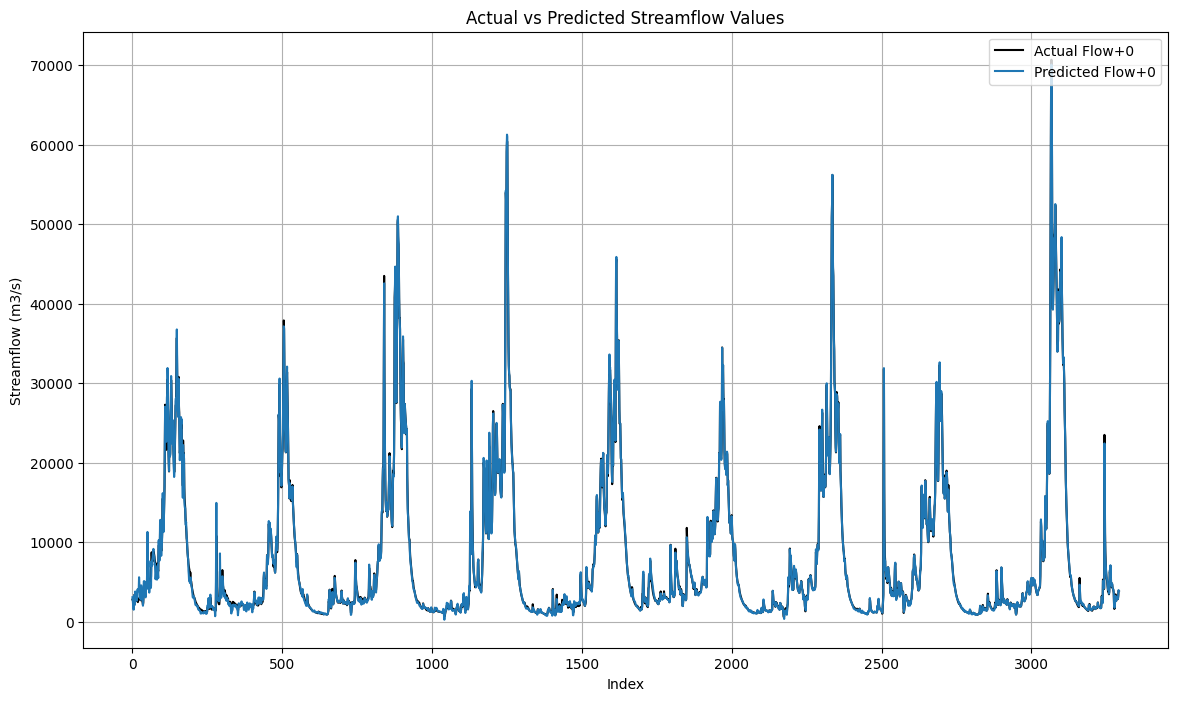

In [402]:
plt.figure(figsize=(14, 8))

# # Plot Actual vs Predicted for each Flow
# for i in range(y_pred.shape[0]):
#     plt.plot(range(len(y_test)), y_test[:, i], label=f'Actual Flow+{i}', color='black')
#     plt.plot(range(len(y_pred)), y_pred[:, i], label=f'Predicted Flow+{i}', color=f'C{i}')

plt.plot(range(len(y_test)), y_test, label=f'Actual Flow+0', color='black')
plt.plot(range(len(y_pred)), y_pred, label=f'Predicted Flow+0', color=f'C0')

plt.xlabel('Index')
plt.ylabel('Streamflow (m3/s)')
plt.title('Actual vs Predicted Streamflow Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [405]:
# Define the range of indices you want to zoom in on
zoom_start = 1400  # Start index for zoom
zoom_end = 1500    # End index for zoom


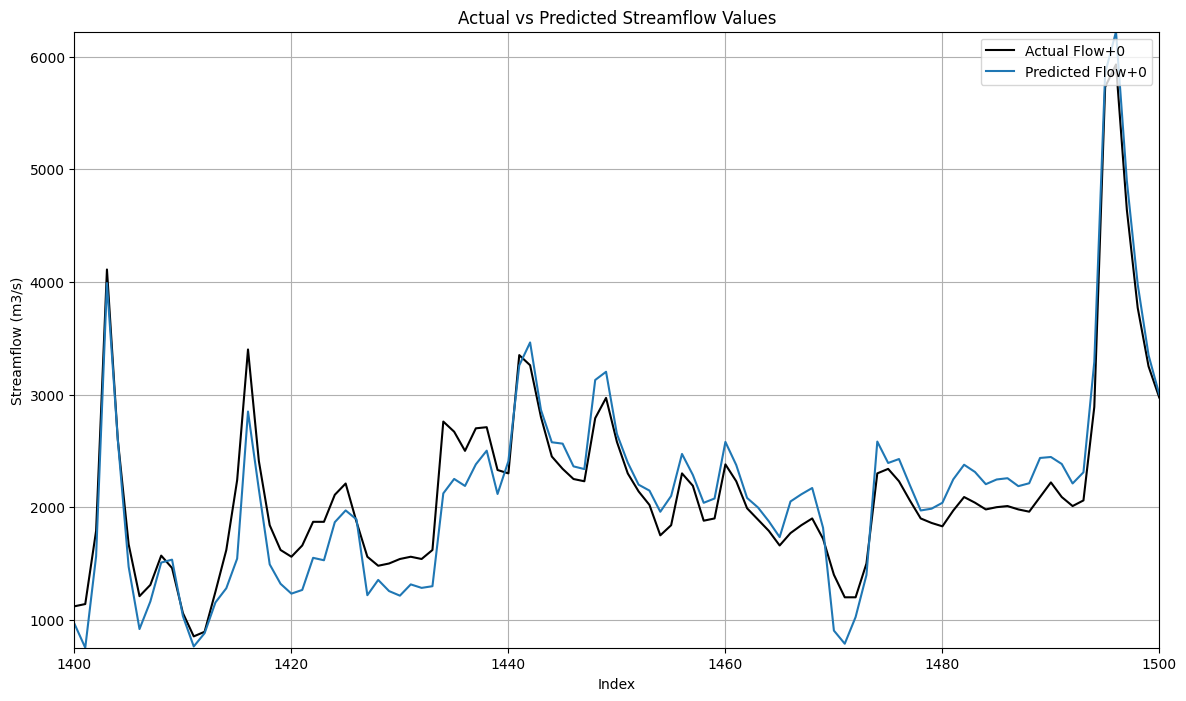

In [406]:

plt.figure(figsize=(14, 8))

# Plot Actual vs Predicted for Flow+0
plt.plot(range(len(y_test)), y_test, label='Actual Flow+0', color='black')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Flow+0', color='C0')

plt.xlabel('Index')
plt.ylabel('Streamflow (m3/s)')
plt.title('Actual vs Predicted Streamflow Values')

# Set the x and y limits to zoom in
plt.xlim(zoom_start, zoom_end)
plt.ylim(min(y_test[zoom_start:zoom_end].min(), y_pred[zoom_start:zoom_end].min()), 
         max(y_test[zoom_start:zoom_end].max(), y_pred[zoom_start:zoom_end].max()))

plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
df = loadData('Data/Idaho/13340000_streamflow_qc.txt', 'Data/Idaho/13340000_lump_maurer_forcing_leap.txt')

Y = df['Flow0']  # Target variable
adjX = df.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
X = adjX.columns



# from sklearn.inspection import permutation_importance

# # Calculate permutation importance
# perm_importance = permutation_importance(model, x_test, y_test, n_repeats=10, random_state=42)

# # Plot feature importances
# feature_names = X.columns
# sorted_idx = perm_importance.importances_mean.argsort()

# plt.figure(figsize=(10, 6))
# plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel('Permutation Importance')
# plt.title('Feature Importance')
# plt.show()


# Read the .txt file into a DataFrame
# If the delimiter is not a comma, adjust the 'delimiter' parameter accordingly
new_df1 = pd.read_csv('Data/Idaho/05131500_streamflow_qc.txt', delim_whitespace=True, header=None)  # For whitespace-separated

# Assign column headers
new_df1.columns = ['ID', 'Year', 'Mnth', 'Day', 'Flow0', 'SYM']

new_df1.drop(['ID', 'Year', 'Mnth', 'Day'], axis=1, inplace=True)

# If the delimiter is not a comma, adjust the 'delimiter' parameter accordingly
new_df2 = pd.read_csv('Data/Idaho/05131500_lump_maurer_forcing_leap.txt', skiprows=3, delim_whitespace=True)  # For whitespace-separated


# Concatenate horizontally
new_df = pd.concat([new_df1, new_df2], axis=1)

new_df = pd.get_dummies(new_df, columns=['SYM'], dummy_na=True)

new_df.drop(['Mnth', 'Day', 'Hr'], axis=1, inplace=True)


# # Create new columns with flow values before 1 day, 2 days, 3 days
new_df['Flow-1'] = new_df['Flow0'].shift(+1)  # Shift up by 1
new_df['Flow-2'] = new_df['Flow0'].shift(+2)  # Shift up by 2
new_df['Flow-3'] = new_df['Flow0'].shift(+3)  # Shift up by 3
# # Create new columns with flow values after 1 day, 2 days, 3 days
new_df['Flow+1'] = new_df['Flow0'].shift(-1)  # Shift up by 1
new_df['Flow+2'] = new_df['Flow0'].shift(-2)  # Shift up by 2
new_df['Flow+3'] = new_df['Flow0'].shift(-3)  # Shift up by 3

new_df = new_df.dropna()

Y2 = new_df[['Flow+1']]  # Target variable
X2 = new_df.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features


scaler_X2 = StandardScaler()
scaler_Y2 = StandardScaler()

X_scaled2 = scaler_X.fit_transform(X2)
# Y_scaled = scaler_Y2.fit_transform(Y2.values.reshape(-1, 1)).flatten()
Y_scaled2 = scaler_Y.fit_transform(Y2)


y_pred_scaled2 = model.predict(X_scaled2)

# Inverse transform predictions
y_pred2 = scaler_Y.inverse_transform(y_pred_scaled2)
y_pred2 = np.maximum(y_pred2, 0)  # Ensure no negative predictions


# Initialize lists to store the metrics
mae_list = []
mse_list = []
rmse_list = []
r2_list = []
mape_list = []
accuracy_list = []

# Small value to avoid division by zero
epsilon = 1e-10

# Loop through each target variable (Flow0, Flow+1, etc.)
for i in range(y_pred.shape[1]):
    # Calculate errors
    errors = abs(y_pred[:, i] - y_test[:, i])

    # Mean Absolute Error (MAE)
    mae = np.mean(errors)
    mae_list.append(mae)
    print(f"Mean Absolute Error (Flow +{i}): {round(mae, 2)} m3/s")

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    mse_list.append(mse)
    print(f"Mean Squared Error (Flow +{i}): {round(mse, 2)}")

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    print(f"Root Mean Squared Error (Flow +{i}): {round(rmse, 2)}")

    # R-squared (R²)
    r_squared = r2_score(y_test[:, i], y_pred[:, i])
    r2_list.append(r_squared)
    print(f"R-squared (Flow +{i}): {round(r_squared, 2)}")

    # Mean Absolute Percentage Error (MAPE)
    mape = 100 * (errors / (y_test[:, i] + epsilon))  # Add epsilon to avoid division by zero
    mean_mape = np.mean(mape)
    mape_list.append(mean_mape)
    print(f"MAPE (Flow +{i}): {round(mean_mape, 2)}%")
    
    # Calculate accuracy (100% - MAPE)
    accuracy = 100 - mean_mape
    accuracy_list.append(accuracy)
    print(f"Accuracy (Flow +{i}): {round(accuracy, 2)}%\n")


# Define the range of indices you want to plot
start_index = 2000
end_index = 2100



# Ensure indices are within bounds
start_index = max(start_index, 0)
end_indexY = min(end_index, len(Y2))
end_indexX = min(end_index, len(X2))

# Slice the arrays
Y2_subset = Y2.iloc[start_index:end_indexY]
y_pred2_subset = y_pred2[start_index:end_indexY]
X2_subset = X2[start_index:end_indexX]

plt.figure(figsize=(14, 8))

# Plot Actual vs Predicted for each Flow
#Define a color map for features
colors = plt.cm.BuPu(np.linspace(0, 1, X2.shape[1]))

# Plot each feature with a different color
for i in range(2, X2.shape[1]):
    plt.plot(range(len(X2_subset)), X2_subset.iloc[:, i], color=colors[i], label=f'Feature {i+1}')
plt.plot(range(len(Y2_subset)), Y2_subset.iloc[:, 0], color='orange', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 1], color='blue', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 2], color='blue', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 3], color='blue', label='Actual Values')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 0], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 1], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 2], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 3], color='green', label='Feature')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset, color='red', label='Predicted Flow0')
plt.plot(range(len(y_pred2_subset)), y_pred2_subset[:, 0], color='red', label='Predicted Flow0')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 1], color='red', label='Predicted Flow+1')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 2], color='red', label='Predicted Flow+2')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 3], color='red', label='Predicted Flow+3')

plt.xlabel('Index')
plt.ylabel('Streamflow (m3/s)')
plt.title('Actual vs Predicted Streamflow Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
